In [3]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
from tqdm import tqdm
import torch

**Lets take look at data**

In [4]:
def unique(list1):
    x = np.array(list1)
    return np.unique(x)

In [5]:
def cheack_dataset(path, name):
    imgs = []
    imgs_name = []
    dims = []
    valid_images = [".jpg",".bmp",".png",".jpeg"]
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_images:
            continue
        img = cv2.imread(os.path.join(path,f))
        imgs.append(img)
        imgs_name.append(f)
        dims.append(str(img.shape))
    
    print(name+" size: ", len(imgs))
    print(name+" images dimentions: ", unique(dims)[0])
    
    return imgs, imgs_name

In [8]:
def visualize(imgs):
    fig = plt.figure(figsize=(20, 5))
    for i in range(1, 11):
        fig.add_subplot(2, 5, i)
        plt.imshow(imgs[i-1])
    print("The first 10 images: ")
    plt.show()

train size:  1120
train images dimentions:  (640, 640, 3)
The first 10 images: 


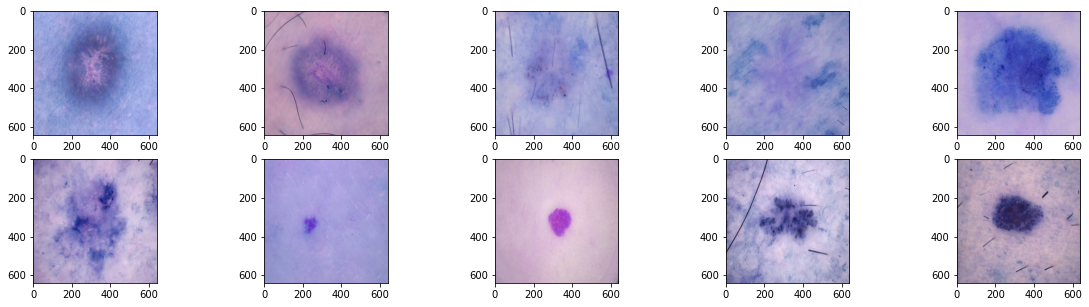

In [9]:
# train set

path = "../data/raw/train/images"
train_imgs, train_imgs_name = cheack_dataset(path, "train")
visualize(train_imgs)

train size:  160
train images dimentions:  (640, 640, 3)
The first 10 images: 


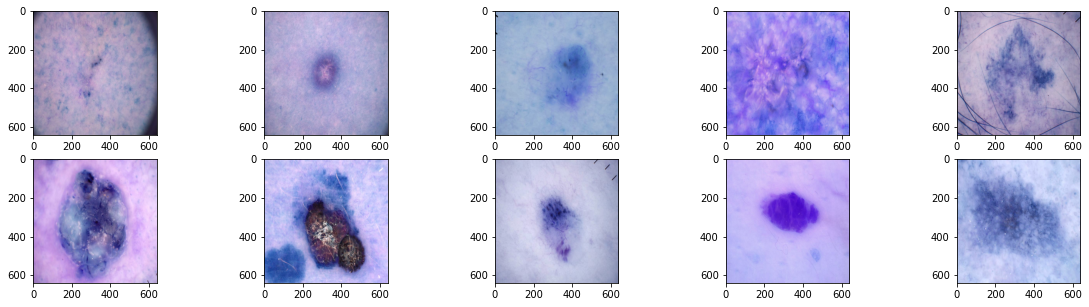

In [10]:
# val set

path = "../data/raw/valid/images"
val_imgs, _ = cheack_dataset(path, "train")
visualize(val_imgs)

test size:  320
test images dimentions:  (640, 640, 3)
The first 10 images: 


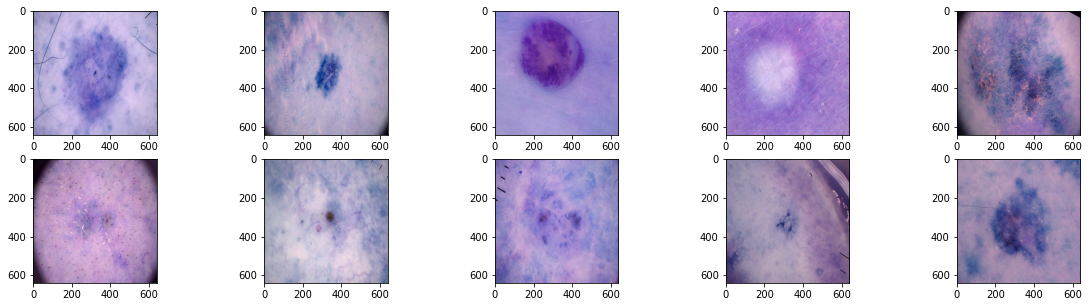

In [11]:
# test set

path = "../data/raw/test/images"
test_imgs, _ = cheack_dataset(path, "test")
visualize(test_imgs)



---



# **Preprocessing data**
1. Grayscale conversion
2. Normalization
3. Data Augmentation:


*Since the dataset has already been divided into train-set, validation-set, and test-set, and also it has been shuffled, there is no need to do these things again.*

**1.Grayscale conversion:**
Since the color of the images may have an effect on the diagnosis of cancerous skin appendages, lets skip this part for now

**2.Normalization**

In [27]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import sys
 
# adding loader_directory to the system path
sys.path.insert(0, '../src/data')

from loader import CancerDataLoader

csv_root = '../data/raw/train'
img_root = '../data/raw/train/images'
batch_size = 32

my_transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(256),
    transforms.ToTensor(),
    # here do not use transforms.Normalize(mean, std)
])


train_loader = CancerDataLoader(img_root=img_root, csv_root=csv_root, transform=my_transform)
train_loader = DataLoader(train_loader, batch_size=batch_size, shuffle=False, num_workers=0)

torch.Size([32, 3, 640, 640])


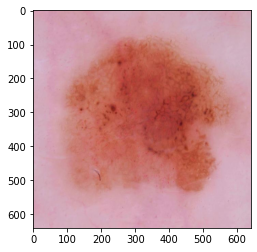

In [28]:
# visualize an image

images, labels, _ = next(iter(train_loader))
print(images.shape)
def display_image(images):
  images_np = images.numpy()
  img_plt = images_np.transpose(0,2,3,1)
  # display 5th image from dataset
  plt.imshow(img_plt[4])

display_image(images)

In [29]:
# calculate mean and std

"""
# One batch
def mean_std(loader):
  images, lebels, _ = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
"""

def batch_mean_and_sd(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, label, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean,std

mean, std = batch_mean_and_sd(train_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.7512, 0.5606, 0.5861]) tensor([0.1347, 0.1464, 0.1615])


In [30]:
# normalize the images

csv_root = '../data/raw/train'
img_root = '../data/raw/train/images'

my_transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,
                         std= std)
])


normalized_train_loader = CancerDataLoader(img_root=img_root, csv_root=csv_root, transform=my_transform)
normalized_train_loader = DataLoader(normalized_train_loader, batch_size=batch_size, shuffle=False, num_workers=0)

In [31]:
mean, std = batch_mean_and_sd(normalized_train_loader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([ 8.3378e-07, -1.5272e-07, -6.4741e-07]) tensor([1.0000, 1.0000, 1.0000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


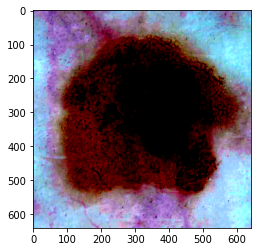

In [32]:
images_normal, labels, imgs_name = next(iter(normalized_train_loader))
display_image(images_normal)

**3.Data Augmentation:**
*yolo will augment the dataset by default*


# **Save images as processed data**

In [33]:
images_normal.shape

torch.Size([32, 3, 640, 640])

In [34]:
from torchvision.utils import save_image
save_dir = "../data/processed/images"
for images_normal, labels, imgs_name in iter(normalized_train_loader):
    for i, img in enumerate(images_normal):
        save_image(img, save_dir+'/'+imgs_name[i])
        
print("save directory: ", save_dir)

save directory:  ../data/processed
